In [27]:
import sys
sys.path.append("/users/himankat/.local/lib/python3.9/site-packages")

In [2]:
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
import numpy as np
#%matplotlib ipympl
import matplotlib.pyplot as plt
from pysteps import nowcasts, motion
from scipy.sparse.linalg import LinearOperator
import scipy.sparse as sp

from analyze.visualize import plot_time_steps, plot_flow
from analyze.animate import create_animation
from models.unet import UNet
from models.basisfunction import BasisFunctionModel
from data.dataloaders import SSTDataModule, CloudDataModule
from models.utils import mask, warp

Pysteps configuration file found at: /users/himankat/.local/lib/python3.9/site-packages/pysteps/pystepsrc



In [3]:
def warp_simple(X, u, v, dx=1.0, dy=1.0, dt=1.0):
    ny, nx = X.shape
    xi, yi = np.meshgrid(np.arange(nx), np.arange(ny))

    i = (xi - u*dt/dx).astype(int)
    j = (yi - v*dt/dy).astype(int)

    # Create a mask for valid i, j indices
    valid_mask = (i >= 0) & (i < nx) & (j >= 0) & (j < ny)
    
    i = np.maximum(np.minimum(i, nx - 1), 0)
    j = np.maximum(np.minimum(j, ny - 1), 0)

    y = X.reshape(ny, nx)[j, i] #.reshape(X.shape)
    
    # Apply the mask to set invalid positions to np.NaN
    y[~valid_mask] = np.NaN

    return y

### Load trained model parameters

In [4]:
CKPT_PATH = '/scratch/project_2001027/adafume/deepide/etkf_example_data/model_checkpoint.ckpt'

In [5]:
CKPT_PATH = '/scratch/project_2001027/adafume/deepide/lightning_logs/version_173/checkpoints/epoch=3-step=880.ckpt'
checkpoint = torch.load(CKPT_PATH)
model = BasisFunctionModel.load_from_checkpoint(checkpoint_path=CKPT_PATH)
#model = UNet.load_from_checkpoint(checkpoint_path=CKPT_PATH)
model = model.eval()
lags = checkpoint["hyper_parameters"]["in_channels"]
masking = checkpoint["hyper_parameters"]["masking"]
# Number of lags in inference need to be same as in training
lags

3

In [6]:
hparams = checkpoint["hyper_parameters"]
hparams["warping_mode"] = "nearest" # Change warping interpolation to nearest point for inference
hparams

{'lr': 3e-08,
 'in_channels': 3,
 'start_channels': 64,
 'basis_n': 6,
 'coordinate_interval': [-1.0, 1.0],
 'img_size': 128,
 'basis': <function models.basisfunction.polynomial_basis(coordinate: torch.Tensor, basis_n: int) -> torch.Tensor>,
 'out_channels': 6,
 'resnet_blocks': [3, 3, 3, 3, 3],
 'warping_mode': 'nearest',
 'masking': 0.15,
 'test_point': True}

In [7]:
model = BasisFunctionModel(**hparams)
#model = UNet(**hparams)
model.load_state_dict(checkpoint['state_dict'])
model = model.eval()

### Trained model performance

In [11]:
data_dir="/scratch/project_2001027/adafume/deepide/data/highres/S_NWC_CMIC_COT_2021-04-01_2021-09-29_cubic_resampling_utm_finland_NN_input_"+str(hparams["img_size"])+"_unnorm.nc"
#data_dir="/scratch/project_2001027/adafume/deepide/data/highres/S_NWC_CMIC_COT_2021-04-01_2021-09-29_cubic_resampling_utm_finland_NN_input_"+str(hparams["img_size"])+".nc"
#data_dir="./test_data.nc"
datamodule =  CloudDataModule(data_dir=data_dir,
                              lags=lags, interval=1, steps=8)
trainer = pl.Trainer(accelerator='gpu',
                         enable_progress_bar=True,
                         enable_checkpointing=True,
                         logger=True,
                         max_epochs=1)
trainer.validate(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


t+1 MSE loss: 0.0089	t+2 MSE loss: 0.0181	t+3 MSE loss: 0.0160	t+4 MSE loss: 0.0182	

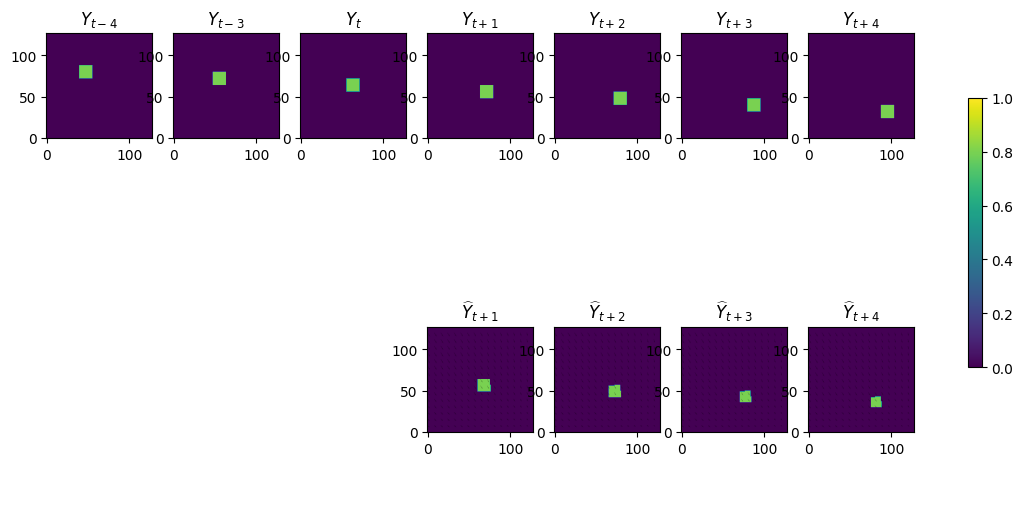

In [12]:
gaus = np.load('square.npy')
gaus = np.flip(gaus, 1)
sample = torch.tensor(gaus[6:13].copy(), device='cuda').float()
#sample = F.pad(sample, [32]*4).unsqueeze(0)*4
sample = F.upsample(sample.unsqueeze(0), size=(256,256), mode="nearest")*0.8
sample = sample[...,64:192,64:192]
output, flow, _ = model.predict_step(sample[:,0:lags],0)
print("t+1 MSE loss: {:0.4f}".format(F.mse_loss(mask(output[:,-1], masking), mask(sample[:,lags], masking)).item()), end="\t")
predictions = output[:,-1]
#flow =( flow * (flow.shape[2] - 1)) / 2
vectors = flow
for i in range(sample.shape[1]-lags-1):
    #output, flow = model.predict_step(output, 0)
    output = warp(predictions[-1].unsqueeze(0), flow, "nearest")
    y_hat = output[:,-1]
    y = sample[:,i+lags]
    loss = F.mse_loss(mask(y_hat, masking), mask(y, masking)).item()
    print("t+{} MSE loss: {:0.4f}".format(i+2, loss), end="\t")
    predictions = torch.cat([predictions, y_hat], dim=0)
    vectors = torch.cat([vectors, flow], dim=0)
f = plot_time_steps(sample.squeeze(), predictions, vectors, vlim=[0,1])
plt.show()
create_animation(predictions.cpu().detach().numpy(), vectors.cpu().detach().numpy(), None, data2=sample[0][-predictions.shape[0]:].cpu().detach().numpy(), vlim=[0,1])

In [61]:
import xarray as xr
ds = xr.open_dataset(data_dir)
ds = ds.groupby("timei")

In [69]:
range(int(0.9 * len(ds)), len(ds))

range(163, 182)

In [76]:
182-163

19

### Naive prediction performance

In [108]:
for i, sample in enumerate(datamodule.test_dataloader()):
    sample = sample[0,:,28:156,28:156]
    if i == 10:
        break
create_animation(sample.cpu().detach().numpy(), torch.zeros(11,2, hparams["img_size"], hparams["img_size"]).cpu().detach().numpy(), None, data2=sample.squeeze().cpu().detach().numpy())
    

In [34]:
loss = np.zeros(8)
for sample in datamodule.test_dataloader():
    batch_loss = 0
    masked_pred = mask(sample[:,lags-1], 0.15).squeeze()
    for i in range(sample.shape[1] - lags):
        masked_next = mask(sample[:,i+lags], 0.15).squeeze()
        #batch_loss += F.mse_loss(masked_pred, masked_next).item()
        loss[i] += np.nanmean((masked_pred - masked_next)**2)
    
print("Loss:", loss/len(datamodule.test_dataloader()))

Loss: [0.31557256 0.51070019 0.64815326 0.77462755 0.89047269 0.96495964
 0.96028227 0.8826976 ]


### PySTEPS LK method performance

In [138]:
LK(sample[0:lags].cpu().detach().numpy(), leadtime)

array([[[-0.05925789, -0.05997492, -0.06070139, ..., -0.09056585,
         -0.08701761, -0.08340275],
        [-0.05908246, -0.05980862, -0.06054459, ..., -0.09273403,
         -0.08891801, -0.08501007],
        [-0.05889528, -0.05963056, -0.06037605, ..., -0.09512   ,
         -0.09099298, -0.08673722],
        ...,
        [ 2.39801186,  2.400317  ,  2.4027986 , ...,  2.16992342,
          2.16284034,  2.16342046],
        [ 2.40233306,  2.40474018,  2.40732741, ...,  2.21612782,
          2.20410913,  2.1981961 ],
        [ 2.40651562,  2.40900387,  2.41167063, ...,  2.25246891,
          2.23786269,  2.2280748 ]],

       [[-6.86923292, -6.87002467, -6.87082817, ..., -7.3688159 ,
         -7.35774011, -7.34601973],
        [-6.86808172, -6.86886932, -6.86966859, ..., -7.38487851,
         -7.37260711, -7.35954389],
        [-6.86691555, -6.86769887, -6.86849376, ..., -7.4024248 ,
         -7.38875949, -7.3740964 ],
        ...,
        [-5.75540885, -5.73777562, -5.71831845, ..., -

In [139]:
def LK(I, n_leadtimes):
    dense_lucaskanade = motion.get_method("LK")
    u2,v2 = dense_lucaskanade(I)
    w = np.stack((u2,v2))
    return w

loss = 0
a = False
for batch_idx, batch in enumerate(datamodule.test_dataloader()):
    batch_loss = 0
    print("Progress:", batch_idx/len(datamodule.test_dataloader()), end="\r")
    for i, sample in enumerate(batch):
        leadtime = sample.shape[0] - lags
        predictions = torch.tensor(LK(sample[0:lags].cpu().detach().numpy(), leadtime))
        actual = sample[lags:]
        masked_pred = mask(predictions, 0.15).cpu().detach().numpy()
        masked_actual = mask(actual, 0.15).cpu().detach().numpy()
        single_loss = np.nanmean((masked_pred - masked_actual)**2, axis=(1,2))
        batch_loss += single_loss
    loss += batch_loss
#print("Loss:", loss/len(datamodule.test_dataloader()))

KeyboardInterrupt: 

In [127]:
for batch_idx, batch in enumerate(datamodule.test_dataloader()):
    batch_loss = 0
    print("Progress:", batch_idx/len(datamodule.test_dataloader()), end="\r")
    for i, sample in enumerate(batch):
        leadtime = sample.shape[0] - lags
        predictions = torch.tensor(LK(sample[0:lags].cpu().detach().numpy(), leadtime))
        actual = sample[lags:]
        masked_pred = mask(predictions, 0.15).cpu().detach().numpy()
        masked_actual = mask(actual, 0.15).cpu().detach().numpy()
        single_loss = np.nanmean((masked_pred - masked_actual)**2, axis=(1,2))
        batch_loss += single_loss
    loss += batch_loss
#print("Loss:", loss/len(datamodule.test_dataloader()))

KeyboardInterrupt: 

In [245]:
output_lk[80:85, 109:112] = np.nan

In [246]:
~np.isnan(output_lk) & valid_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

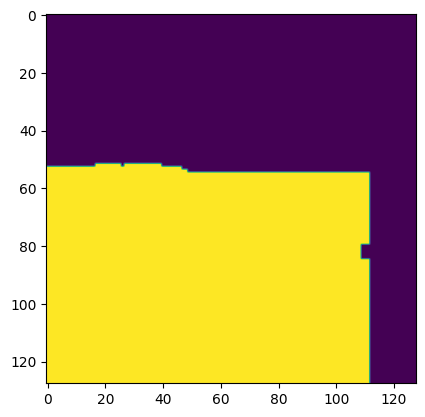

In [261]:
plt.imshow(valid_maskk)

In [259]:
valid_maskk = valid_mask.copy()
valid_maskk[80:85, 109:112] = False

In [270]:
np.argmax(~valid_maskk[:,max_col])

0

In [271]:
~valid_maskk[:,max_col]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]

In [273]:
np.argmin(~(valid_maskk[:,max_col])[::1])

55

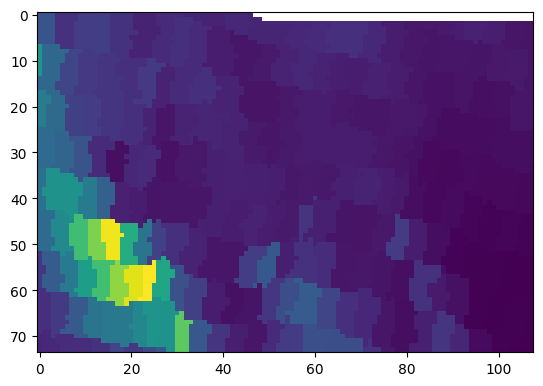

In [282]:
from scipy import ndimage

def largest_rect_from_mask(mask):
    # Initial boundary setting
    largest_rect_coords = np.argwhere(mask)
    min_row, min_col = largest_rect_coords.min(axis=0)
    max_row, max_col = largest_rect_coords.max(axis=0)

    # Locate the first "even" row from top
    previous = 0
    for row in range(min_row, max_row + 1):
        row_values = mask[row, min_col:max_col + 1]
        first_valid = np.argmax(row_values)
        last_valid = len(row_values) - np.argmax(row_values[::-1]) - 1
        if np.all(row_values[first_valid:last_valid + 1]):
            min_row = row
            break
            
    # Locate the first "even" row from bottom
    for row in range(max_row, min_row - 1, -1):
        row_values = mask[row, min_col:max_col + 1]
        first_valid = np.argmax(row_values)
        last_valid = len(row_values) - np.argmax(row_values[::-1]) - 1
        if np.all(row_values[first_valid:last_valid + 1]):
            max_row = row
            break
            
    # Locate the first "even" column from left
    for col in range(min_col, max_col + 1):
        col_values = mask[min_row:max_row + 1, col]
        first_valid = np.argmax(col_values)
        last_valid = len(col_values) - np.argmax(col_values[::-1]) - 1
        if np.all(col_values[first_valid:last_valid + 1]):
            min_col = col
            break
            
    # Locate the first "even" column from right
    for col in range(max_col, min_col - 1, -1):
        col_values = mask[min_row:max_row + 1, col]
        first_valid = np.argmax(col_values)
        last_valid = len(col_values) - np.argmax(col_values[::-1]) - 1
        if np.all(col_values[first_valid:last_valid + 1]):
            max_col = col
            break

    return min_row, max_row, min_col, max_col


min_row, max_row, min_col, max_col = largest_rect_from_mask(valid_maskk)
plt.imshow(output_lk[min_row:max_row, min_col:max_col])

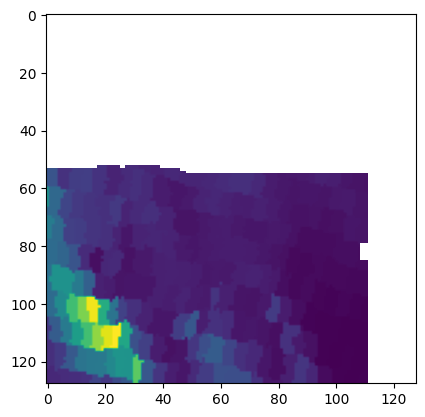

In [275]:
plt.imshow(output_lk)

In [88]:
def find_largest_rect_from_mask(valid_mask):
    # Find first and last row with valid values
    min_row = None
    max_row = None
    for i in range(valid_mask.shape[0]):
        if np.any(valid_mask[i, :]):
            min_row = i if min_row is None else min_row
            max_row = i
    
    # Find first and last column with valid values
    min_col = None
    max_col = None
    for j in range(valid_mask.shape[1]):
        if np.any(valid_mask[:, j]):
            min_col = j if min_col is None else min_col
            max_col = j
    
    if min_row is None or min_col is None:
        return None  # Return None if there's no valid rectangle

    # Extract the rectangle from the mask
    largest_rect_mask = valid_mask[min_row:max_row+1, min_col:max_col+1]

    # Identify rows and columns containing only True within this largest rectangle
    fully_valid_rows = np.all(largest_rect_mask, axis=1)
    fully_valid_cols = np.all(largest_rect_mask, axis=0)
    
    # Refine rectangle to only include fully valid rows and columns
    largest_rect_mask = largest_rect_mask[fully_valid_rows, :]
    largest_rect_mask = largest_rect_mask[:, fully_valid_cols]

    return min_row, max_row, min_col, max_col, largest_rect_mask, fully_valid_rows, fully_valid_cols

min_row, max_row, min_col, max_col, largest_rect_mask, fully_valid_rows, fully_valid_cols = find_largest_rect_from_mask(valid_mask)

In [56]:
min_row

53

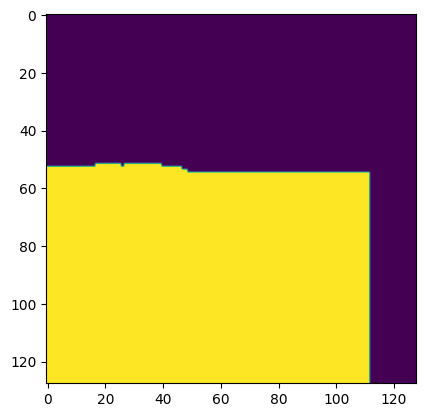

In [125]:
plt.imshow(valid_mask)

In [128]:
np.max(np.sum(valid_mask, axis=1))

112

In [130]:
np.min(np.where(np.sum(valid_mask, axis=1) == 112))

55

In [205]:
import numpy as np

def find_largest_rectangle(valid_mask):
    rows, cols = valid_mask.shape
    max_area = 0
    min_row, max_row, min_col, max_col = 0, 0, 0, 0

    # Calculate prefix sum to accelerate the check of all True in a submatrix
    prefix_sum = np.zeros((rows + 1, cols + 1), dtype=int)
    for i in range(1, rows + 1):
        for j in range(1, cols + 1):
            prefix_sum[i][j] = valid_mask[i-1][j-1] + prefix_sum[i-1][j] + prefix_sum[i][j-1] - prefix_sum[i-1][j-1]

    for top_row in range(rows):
        for bottom_row in range(top_row + 1, rows + 1):  # bottom_row is exclusive
            for left_col in range(cols):
                for right_col in range(left_col + 1, cols + 1):  # right_col is exclusive

                    # Calculate the number of True values in this submatrix
                    num_trues = prefix_sum[bottom_row][right_col] - prefix_sum[top_row][right_col] - prefix_sum[bottom_row][left_col] + prefix_sum[top_row][left_col]

                    # Calculate the total area of this submatrix
                    area = (bottom_row - top_row) * (right_col - left_col)

                    # Check if all values are True in this submatrix
                    if num_trues == area:
                        if area > max_area:
                            max_area = area
                            min_row, max_row, min_col, max_col = top_row, bottom_row, left_col, right_col

    return min_row, max_row, min_col, max_col



# Create the original array and the valid_mask
result1 = np.ones((10, 10))
result1[:3, :] = np.nan
result1[:, 8:] = np.nan
result1[5, 7] = np.nan  # This is okay because it's on the border
result1[3, 4] = np.nan 
valid_maskk = ~np.isnan(result1)

find_largest_rectangle(valid_mask)

KeyboardInterrupt: 

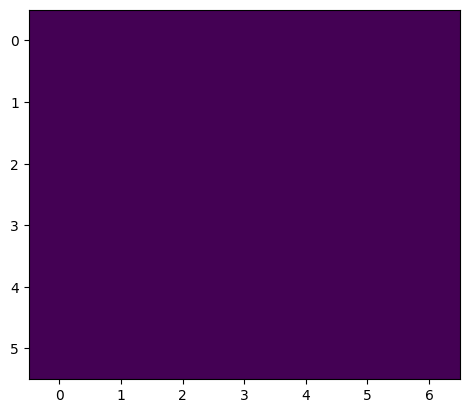

In [201]:
plt.imshow((result1[4:10,0:7]))

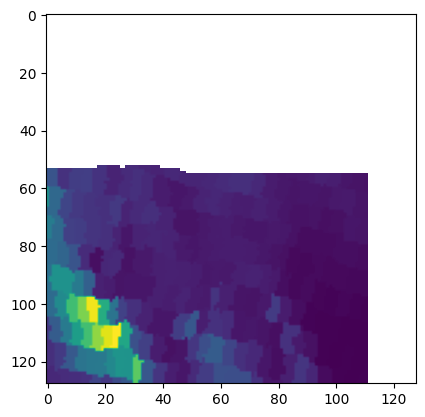

In [134]:
plt.imshow(output_lk)

In [162]:
v = v*1.0
v[v == 0.0] = np.nan
v
np.nansum(v, axis=0)

array([75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 76., 76., 76., 76., 76., 76., 76., 76., 76.,
       75., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76.,
       76., 75., 75., 75., 75., 75., 75., 75., 74., 74., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [161]:
v = valid_mask.copy()
v *1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [167]:
col_sums = np.sum(valid_mask, axis=1)*1.0
col_sums[col_sums == 0.0] = np.nan
np.nanmin(col_sums)

22.0

In [168]:
col_sums

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  22.,  47.,  49.,
       112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
       112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
       112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
       112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
       112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
       112., 112., 112., 112., 112., 112., 112., 112., 112., 112., 112.,
       112., 112., 112., 112., 112., 112., 112.])

/run/nvme/job_18525720/tmp/ipykernel_3294641/1610760808.py:21: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(output_lk[min_row:max_row, min_col:max_col])


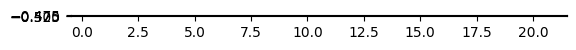

In [163]:
def find_largest_rectangle(valid_mask):
    n, m = valid_mask.shape
    
    # Find where True values start and end in rows
    rowsum = np.sum(valid_mask, axis=1)*1.0
    rowsum[rowsum == 0.0] = np.nan
    row_sum_max = np.nanmin(rowsum)
    valid_rows = np.where(np.nansum(valid_mask, axis=1) == row_sum_max)
    min_row = np.min(valid_rows)
    max_row = np.max(valid_rows)  # +1 to make it exclusive for slicing
    
    # Find where True values start and end in columns
    col_sum_max = np.nanmax(np.nansum(valid_mask, axis=0))
    valid_cols = np.where(np.nansum(valid_mask, axis=0) == col_sum_max)
    min_col = np.nanmin(valid_cols)
    max_col = np.nanmax(valid_cols)  # +1 to make it exclusive for slicing
    
    return min_row, max_row, min_col, max_col

min_row, max_row, min_col, max_col = find_largest_rectangle(valid_mask)
plt.imshow(output_lk[min_row:max_row, min_col:max_col])

In [118]:
max_row

128

In [105]:
result1 = np.ones([10,10])
result1[:3,:] = np.nan
result1[:,8:] = np.nan
result1[5,7] = np.nan
result1[3:,:7]

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [78]:
valid_rows = np.where(np.all(valid_mask, axis=1))[0]
valid_cols = np.where(np.all(valid_mask, axis=0))[0]

# Find rows and columns that contain any valid values
any_valid_rows = np.where(np.any(valid_mask, axis=1))[0]
any_valid_cols = np.where(np.any(valid_mask, axis=0))[0]

# Take intersection of max and min row/column indices
min_row = max(valid_rows[0], any_valid_rows[0])
max_row = min(valid_rows[-1], any_valid_rows[-1])
min_col = max(valid_cols[0], any_valid_cols[0])
max_col = min(valid_cols[-1], any_valid_cols[-1])

# Create a sub-mask based on these intersection indices
sub_mask = valid_mask[min_row:max_row+1, min_col:max_col+1]

# Find any rows or columns in this sub-mask that contain a NaN and remove them
invalid_rows = np.where(np.any(~sub_mask, axis=1))[0]
invalid_cols = np.where(np.any(~sub_mask, axis=0))[0]
if len(invalid_rows) > 0:
    min_row += invalid_rows[0]
    max_row -= invalid_rows[-1]
if len(invalid_cols) > 0:
    min_col += invalid_cols[0]
    max_col -= invalid_cols[-1]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [67]:
valid_rows

array([ 52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

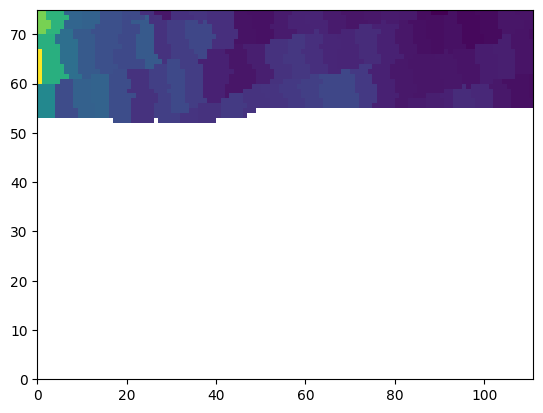

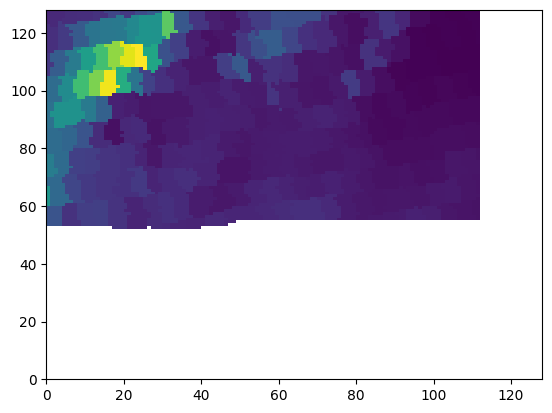

In [45]:
plt.pcolormesh(output_lk)

In [40]:
np.argmax(~np.isnan(output_lk), axis=0)

array([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [37]:
np.argmax(~np.isnan(output_lk), axis=0)

array([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

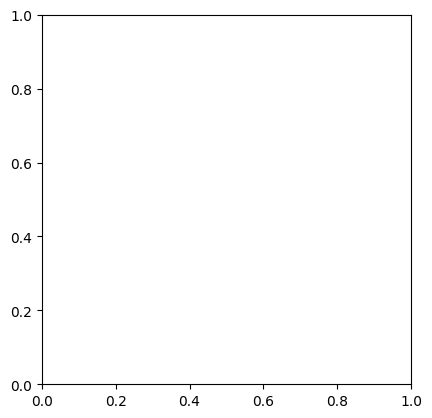

In [37]:
plt.imshow(output_lk)

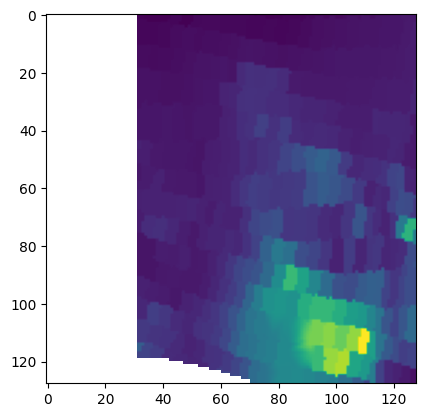

In [36]:
plt.imshow(output_nn)

In [317]:
common_rects = find_common_valid_rect(result1, result2, result3)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10]


In [16]:
def LK(I):
    dense_lucaskanade = motion.get_method("LK")
    u2,v2 = dense_lucaskanade(I)
    w = np.stack((u2,v2))
    return w

In [15]:
x,y = np.meshgrid(np.linspace(0,1,128),np.linspace(0,1,128))

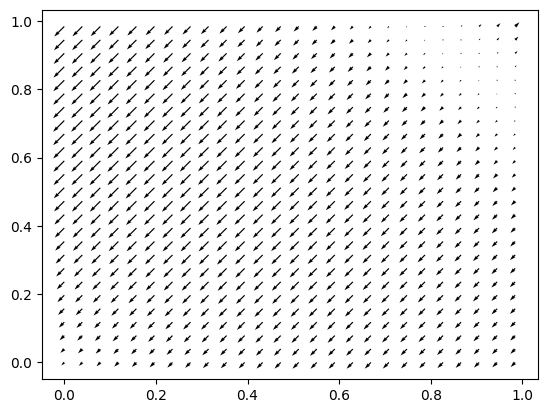

In [270]:
plt.quiver(x[::5,::5],y[::5,::5],uv_nn[0,0].detach().numpy()[::5,::5],uv_nn[0,0].detach().numpy()[::5,::5])

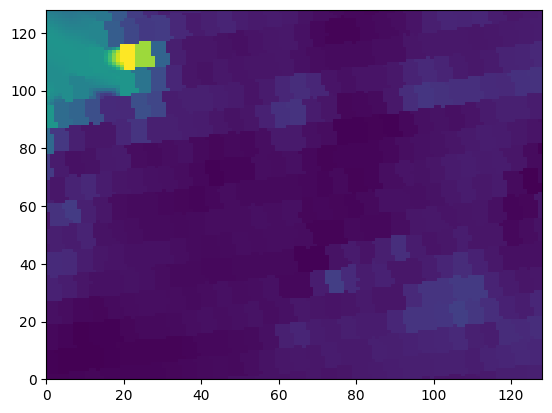

In [284]:
plt.pcolormesh(sample[0,1].detach().numpy())

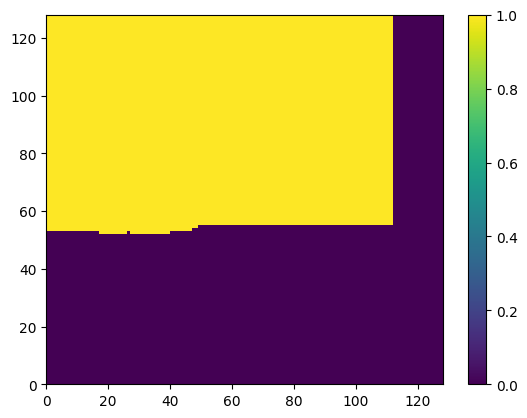

In [42]:
plt.pcolormesh(valid_mask)
plt.colorbar()

In [291]:
output_nn

array([[0.00704235, 0.00704235, 0.00834776, ..., 0.05678537, 0.05678537,
        0.05678537],
       [0.00704235, 0.00704235, 0.00834776, ..., 0.05678537, 0.05678537,
        0.05678537],
       [0.009344  , 0.009344  , 0.009344  , ..., 0.05678537, 0.05678537,
        0.05678537],
       ...,
       [0.15953636, 0.16286202, 0.1660687 , ..., 0.04596421, 0.04596421,
        0.02737928],
       [0.16271293, 0.16584389, 0.1688231 , ..., 0.04596421, 0.02737928,
        0.02737928],
       [0.16747768, 0.17028277, 0.17290124, ..., 0.04596421, 0.02737928,
        0.02737928]], dtype=float32)

In [301]:
find_common_valid_rect(output_lk, output_nn)[0]

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.04163574, 0.04163574,
        0.05709454],
       [       nan,        nan,        nan, ..., 0.04163574, 0.04163574,
        0.04163574],
       [       nan,        nan,        nan, ..., 0.04163574, 0.04163574,
        0.04163574]], dtype=float32)

In [13]:
import pysteps

In [35]:
pysteps.verification.spatialscores.fss(output_nn, output_nn*2, 1, 10)

nan

In [372]:
target = np.ma.masked_array(data = sample[0,lags+i].cpu().detach().numpy(), mask = np.isnan(output_nn)).filled(np.nan)

In [373]:
target

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.23679243, 0.23679243, 0.23679243, ...,        nan,        nan,
               nan],
       [0.23679243, 0.23679243, 0.23679243, ...,        nan,        nan,
               nan],
       [0.23679243, 0.23679243, 0.23679243, ...,        nan,        nan,
               nan]], dtype=float32)

In [321]:
np.sum(np.isnan(np.nan_to_num(output_nn)))

0

In [286]:
output_lk[min_row:max_row, min_col:max_col][np.isnan(output_lk[min_row:max_row, min_col:max_col])] = 0.0
output_lk

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.04826907, 0.05076051, 0.05076051, ...,        nan,        nan,
               nan],
       [0.04826907, 0.05076051, 0.05076051, ...,        nan,        nan,
               nan],
       [0.04826907, 0.05076051, 0.05076051, ...,        nan,        nan,
               nan]], dtype=float32)

In [287]:
output_lk

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.04826907, 0.05076051, 0.05076051, ...,        nan,        nan,
               nan],
       [0.04826907, 0.05076051, 0.05076051, ...,        nan,        nan,
               nan],
       [0.04826907, 0.05076051, 0.05076051, ...,        nan,        nan,
               nan]], dtype=float32)

In [17]:
mse_loss_nn = np.zeros(8)
mse_loss_lk = np.zeros(8)
mse_loss_naive = np.zeros(8)

mae_loss_nn = np.zeros(8)
mae_loss_lk = np.zeros(8)
mae_loss_naive = np.zeros(8)

fss_05_nn = np.zeros(8)
fss_05_lk = np.zeros(8)
fss_05_naive = np.zeros(8)

count = 0
count_fss = 0
model.to('cuda')
for sample_i, sample in enumerate(datamodule.test_dataloader()):
    #sample = sample[:,:,28:156,28:156]
    sample_orig = sample.cpu().detach().numpy()
    sample = scaler(sample)
    #m = sample.mean().cpu().detach().numpy()
    #std = sample.std().cpu().detach().numpy()
    #sample = (sample - m) / std
    print("Progress:", sample_i/len(datamodule.test_dataloader()), end="\r")
    leadtime = sample.shape[1] - lags
    

    _, uv_nn, _ = model.predict_step(sample[:,0:lags].to('cuda'),0)
    uv_lk = LK(sample[0,0:lags].cpu().detach().numpy())
    output_nn = sample[0,lags-1].cpu().detach().numpy()
    output_lk = sample[0,lags-1].cpu().detach().numpy()
    pred_naive = sample[0,lags-1].cpu().detach().numpy()

    mse_loss_nn_step = np.zeros(8)
    mse_loss_lk_step = np.zeros(8)
    mse_loss_naive_step = np.zeros(8)
    mae_loss_nn_step = np.zeros(8)
    mae_loss_lk_step = np.zeros(8)
    mae_loss_naive_step = np.zeros(8)
    fss_05_nn_step = np.zeros(8)
    fss_05_lk_step = np.zeros(8)
    fss_05_naive_step = np.zeros(8)
    
    valid = True
    valid_fss = True
    
    for i in range(sample.shape[1] - lags):
        output_nn = warp_simple(output_nn, uv_nn[0,0].cpu().detach().numpy(), uv_nn[0,1].cpu().detach().numpy())
        output_lk = warp_simple(output_lk, uv_lk[0], uv_lk[1])
        valid_mask = (~np.isnan(output_nn)) & (~np.isnan(output_lk))
        if np.sum(valid_mask) < 16384/3:
            valid = False
            break

        """
        largest_rect_coords = np.argwhere(valid_mask)
        min_row, min_col = largest_rect_coords.min(axis=0)
        max_row, max_col = largest_rect_coords.max(axis=0)
        fss_pred_nn = output_nn[min_row:max_row, min_col:max_col]
        fss_pred_lk = output_lk[min_row:max_row, min_col:max_col]
        fss_pred_naive = pred_naive[min_row:max_row, min_col:max_col]
        fss_target = sample[0,lags+i].cpu().detach().numpy()[min_row:max_row, min_col:max_col]
    
        fss_valid_mask = (~np.isnan(fss_pred_nn)) & (~np.isnan(fss_pred_lk))
        
        fss_pred_nn = np.ma.masked_array(data = fss_pred_nn, mask = fss_valid_mask).filled(np.nan)
        fss_pred_lk = np.ma.masked_array(data = fss_pred_lk, mask = fss_valid_mask).filled(np.nan)
        """
                      
        masked_pred_nn = (output_nn[valid_mask])
        masked_pred_lk = (output_lk[valid_mask])
        masked_pred_naive = (pred_naive[valid_mask])
        masked_target = sample[0,lags+i].cpu().detach().numpy()[valid_mask]
        
        mse_loss_nn_step[i] += np.mean((masked_pred_nn - masked_target)**2)
        mse_loss_lk_step[i] += np.mean((masked_pred_lk - masked_target)**2)
        mse_loss_naive_step[i] += np.mean((masked_pred_naive - masked_target)**2)
        
        mae_loss_nn_step[i] += np.mean(np.abs(masked_pred_nn - masked_target))
        mae_loss_lk_step[i] += np.mean(np.abs(masked_pred_lk - masked_target))
        mae_loss_naive_step[i] += np.mean(np.abs(masked_pred_naive - masked_target))
        
        fss_pred_nn = np.ma.masked_array(data = output_nn, mask = ~valid_mask).filled(np.nan)
        fss_pred_lk = np.ma.masked_array(data = output_lk, mask = ~valid_mask).filled(np.nan)
        fss_pred_naive = np.ma.masked_array(data = pred_naive, mask = ~valid_mask).filled(np.nan)
        fss_target = np.ma.masked_array(data = sample[0,lags+i].cpu().detach().numpy(), mask = ~valid_mask).filled(np.nan)
        fss_05_nn_step[i] += pysteps.verification.spatialscores.fss(fss_pred_nn, fss_target, 0.5, 5)
        fss_05_lk_step[i] += pysteps.verification.spatialscores.fss(fss_pred_lk, fss_target, 0.5, 5)
        fss_05_naive_step[i] += pysteps.verification.spatialscores.fss(fss_pred_naive, fss_target, 0.5, 5)
        if np.sum(np.isnan(fss_05_nn_step + fss_05_lk_step + fss_05_naive_step)) > 0:
            valid_fss = False
    
    if valid:
        mse_loss_nn += mse_loss_nn_step
        mse_loss_lk += mse_loss_lk_step
        mse_loss_naive += mse_loss_naive_step

        mae_loss_nn += mae_loss_nn_step
        mae_loss_lk += mae_loss_lk_step
        mae_loss_naive += mae_loss_naive_step

        count += 1
    if valid_fss:
        fss_05_nn += fss_05_nn_step
        fss_05_lk += fss_05_lk_step
        fss_05_naive += fss_05_naive_step
        count_fss += 1
        

/users/himankat/.local/lib/python3.9/site-packages/pysteps/utils/cleansing.py:245: UserWarning: Singular matrix during outlier detection
  warnings.warn(f"{err} during outlier detection")


In [408]:
pysteps.verification.spatialscores.fss(fss_pred_nn, fss_target, 10, 1)

0.40505479758443297

In [39]:
np.max(sample_orig)

64.01

In [41]:
np.nanmax(fss_target)

0.44578755

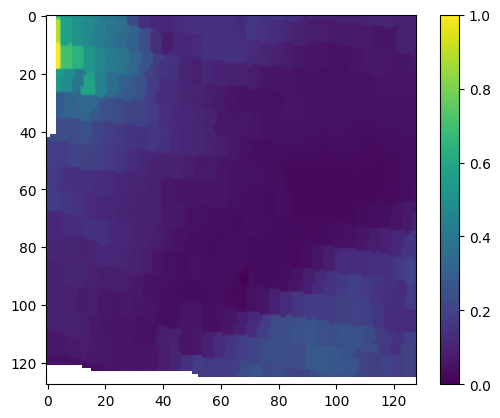

In [46]:
plt.imshow(output_nn)
plt.colorbar()

In [31]:
pysteps.verification.spatialscores.fss(fss_pred_naive, fss_target, 0.5, 5)

nan

In [ ]:
count

443

In [16]:
len(datamodule.test_dataloader())

631

In [18]:
mae_loss_nn/count

array([0.04593692, 0.06405915, 0.07670248, 0.08639832, 0.09433789,
       0.10203682, 0.10822865, 0.11336926])

In [19]:
mae_loss_lk/count

array([0.04232488, 0.05965823, 0.07221683, 0.0826459 , 0.09126299,
       0.09853887, 0.10513083, 0.11177037])

In [20]:
mae_loss_naive/count

array([0.04657366, 0.06860248, 0.08302534, 0.09415203, 0.10359123,
       0.11202101, 0.11895723, 0.12509705])

In [21]:
mse_loss_nn/count

array([0.00614594, 0.01074895, 0.01459483, 0.01788927, 0.02085317,
       0.02402384, 0.02683662, 0.02947479])

In [22]:
mse_loss_lk/count

array([0.00517818, 0.00926325, 0.0128694 , 0.01633907, 0.01954229,
       0.02243342, 0.02533811, 0.02842341])

In [23]:
mse_loss_naive/count

array([0.00635762, 0.01219122, 0.01666103, 0.0206661 , 0.02452978,
       0.02817327, 0.03155731, 0.03487181])

In [24]:
fss_05_nn/count_fss

array([0.56115314, 0.4012244 , 0.29710576, 0.23280209, 0.18682052,
       0.13439911, 0.10098008, 0.08409548])

In [25]:
fss_05_lk/count_fss

array([0.59859308, 0.44802801, 0.34638292, 0.27774223, 0.2210131 ,
       0.16335104, 0.12053218, 0.09616703])

In [26]:
fss_05_naive/count_fss

array([0.51722272, 0.33989148, 0.25247397, 0.19729096, 0.15848955,
       0.12655331, 0.09785977, 0.0852008 ])

In [139]:
def test_point(n: int):
  def intera(x):
    return np.c_[x, x[:,0]*x[:,1], x[:,0]**2, x[:,1]**2]

  V = [[np.cos(phi), np.sin(phi)] for phi in np.linspace(0, 2*np.pi, n)[:-1]]
  V = np.vstack([V, np.zeros((1,2))])
  V = intera(V)
  V = np.c_[np.ones((n,1)), V]
  Vinv = np.linalg.inv(V)
  Vinv[np.abs(Vinv) < 1e-6] = 0.0
  return torch.tensor(Vinv,dtype=torch.float)
def polynomial_basis(coordinate, basis_n: int):
  squared = coordinate.square()
  prod = coordinate.prod(0).unsqueeze(0)
  prod_squared = prod.square()
  const = torch.ones_like(prod_squared)
#coordinate, prod, squared
  basis = torch.cat([const, coordinate, prod, squared]).flatten(1)
  return basis
coordinates = torch.stack(torch.meshgrid([torch.linspace(-1,1,steps=10)]*2, indexing='xy'))

basis = polynomial_basis(coordinates, 6)
Vinv = test_point(6)

In [105]:
test = _.to('cpu')
test = torch.ones_like(test)
test

tensor([[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]])

In [106]:
test.shape

torch.Size([1, 2, 6])

In [162]:
test = torch.zeros(2,6).unsqueeze(2)
test[0,1] = 1
test[0,0] = 2
test.shape

torch.Size([2, 6, 1])

In [163]:
A_i = (Vinv @ test).squeeze(-1)
f = torch.matmul(A_i.unsqueeze(1), basis).view(A_i.shape[0], 10, 10)[0]

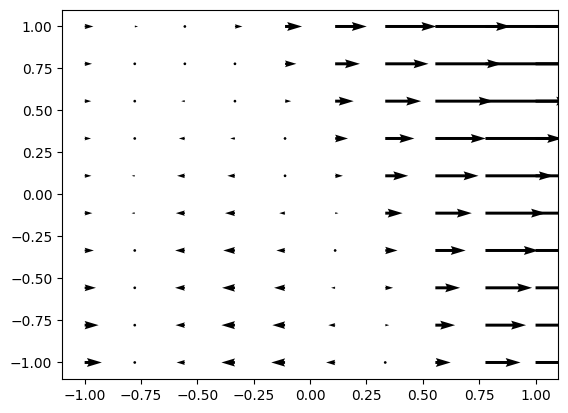

In [164]:
plt.quiver(coordinates[0].detach().numpy(), coordinates[1].detach().numpy(), f.detach().numpy(), 0*f.detach().numpy())

In [161]:
Vv

array([[ 1.        ,  0.        ],
       [ 0.30901699,  0.95105652],
       [-0.80901699,  0.58778525],
       [-0.80901699, -0.58778525],
       [ 0.30901699, -0.95105652],
       [ 0.        ,  0.        ]])

In [159]:
V = [[np.cos(phi), np.sin(phi)] for phi in np.linspace(0, 2*np.pi, 6)[:-1]]
Vv = np.vstack([V, np.zeros((1,2))])
def intera(x):
    return np.c_[x, x[:,0]*x[:,1], x[:,0]**2, x[:,1]**2]
V = intera(Vv)
V = np.c_[np.ones((6,1)), V]

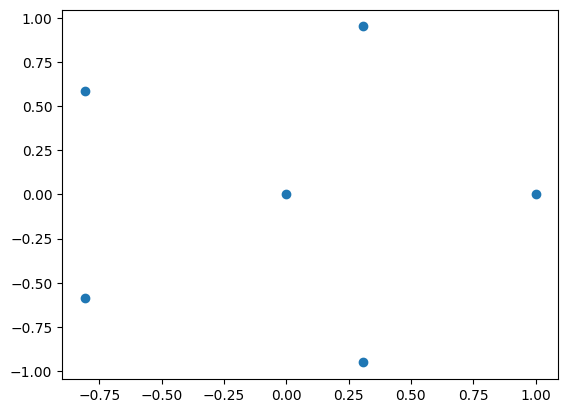

In [160]:
plt.scatter(Vv[:,0],Vv[:,1])

In [50]:
Vinv

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.4000,  0.1236, -0.3236, -0.3236,  0.1236,  0.0000],
        [ 0.0000,  0.3804,  0.2351, -0.2351, -0.3804,  0.0000],
        [ 0.0000,  0.4702, -0.7608,  0.7608, -0.4702,  0.0000],
        [ 0.6000, -0.1236,  0.3236,  0.3236, -0.1236, -1.0000],
        [-0.2000,  0.5236,  0.0764,  0.0764,  0.5236, -1.0000]])

In [347]:
predictions.shape

torch.Size([1, 128, 128])

In [29]:
_

tensor([[[2.1996, 3.6648, 5.0795, 4.7130, 4.1330, 4.4755],
         [1.9506, 1.1248, 1.8879, 1.6683, 1.6265, 0.6487]]], device='cuda:0',
       grad_fn=<StackBackward0>)

Sample 0:
t+1 MSE loss: 0.0018	t+2 MSE loss: 0.0020	t+3 MSE loss: 0.0046	t+4 MSE loss: 0.0078	t+5 MSE loss: 0.0114	t+6 MSE loss: 0.0141	t+7 MSE loss: 0.0158	t+8 MSE loss: 0.0264	

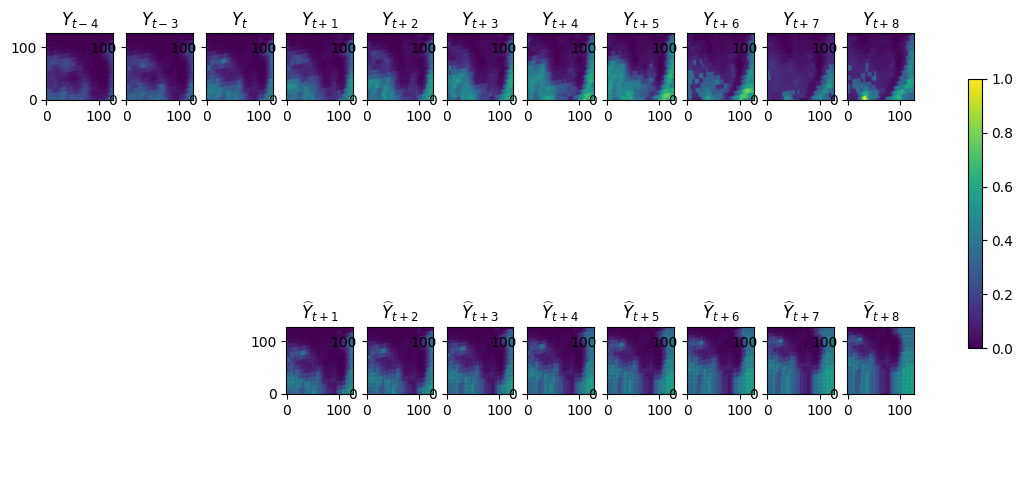

In [32]:
for sample_i, sample in enumerate(datamodule.test_dataloader()):
    #sample = sample[:,:,28:156,28:156]
    #sample = (sample - sample.mean()) / sample.std()
    #sample = sample.to('cuda')
    sample = scaler(sample).to('cuda')
    print("Sample {}:".format(sample_i))
    output, flow, _ = model.predict_step(sample[:,0:lags],0)
    
    flow_lk = torch.tensor(LK(sample[0,0:lags].cpu().detach().numpy())).unsqueeze(0).float().to('cuda')
    predictions_lk = warp(sample[:,lags-1], flow_lk, "nearest")[0]
    
    print("t+1 MSE loss: {:0.4f}".format(F.mse_loss(mask(output[:,-1], masking), mask(sample[:,lags], masking)).item()), end="\t")
    predictions = output[:,-1]
    #flow = 2*flow
    vectors = flow
    vectors_lk = flow_lk
    for i in range(sample.shape[1]-lags-1):
        #output, flow = model.predict_step(output, 0)
        output = warp(predictions[-1].unsqueeze(0), flow, "nearest")
        output_lk = warp(predictions_lk[-1].unsqueeze(0), flow_lk, "nearest")
        y_hat = output[:,-1]
        y = sample[:,i+lags]
        loss = F.mse_loss(mask(y_hat, masking), mask(y, masking)).item()
        print("t+{} MSE loss: {:0.4f}".format(i+2, loss), end="\t")
        predictions = torch.cat([predictions, y_hat], dim=0)
        predictions_lk = torch.cat([predictions_lk, output_lk[:,-1]], dim=0)
        vectors = torch.cat([vectors, flow], dim=0)
        vectors_lk = torch.cat([vectors_lk, flow_lk], dim=0)
    f = plot_time_steps(sample.squeeze(), predictions, vectors, vlim=[0,1])
    plt.show()
    if sample_i == 0:
        break
        
create_animation(torch.cat((sample.squeeze()[0:lags]/0.0, predictions)).cpu().detach().numpy(),
                 torch.cat([torch.zeros(lags, 2, hparams["img_size"], hparams["img_size"]), vectors.cpu()]).cpu().detach().numpy(),
                 None, data2=sample.squeeze().cpu().detach().numpy(), vlim=[0,1])

In [33]:
create_animation(torch.cat((sample.squeeze()[0:lags]/0.0, predictions_lk)).cpu().detach().numpy(),
                 torch.cat([torch.zeros(lags, 2, hparams["img_size"], hparams["img_size"]), vectors_lk.cpu()]).cpu().detach().numpy(),
                 None, data2=sample.squeeze().cpu().detach().numpy(), vlim=[0,1])

In [14]:
def scaler(batch):
    maxx = torch.amax(batch, dim=(1,2,3)).reshape(batch.shape[0],1,1,1)
    minn = torch.amin(batch, dim=(1,2,3)).reshape(batch.shape[0],1,1,1)
    batch = (batch - minn)/(maxx - minn)
    return batch

In [147]:
test = torch.randn(1, 8, 128,128)
scaler(test).max()

tensor(1.)

In [46]:
from models.loss import curl, divergence, gradient

In [56]:
torch.mean(curl(flow[:,:,10:110,10:110]))/(torch.mean(torch.square(flow)))

tensor(0.0101, grad_fn=<DivBackward0>)

In [55]:
torch.mean(divergence(flow[:,:,10:110,10:110]))/(torch.mean(torch.square(flow)))

tensor(0.0051, grad_fn=<DivBackward0>)

In [54]:
torch.mean(gradient(flow[:,:,10:110,10:110]))/(torch.mean(torch.square(flow)))

tensor(0.0013, grad_fn=<DivBackward0>)

In [42]:
torch.mean(torch.zeros(10,10))/1e-40

tensor(0.)

In [37]:
torch.mean(flow)

tensor(0.0034, grad_fn=<MeanBackward0>)

Sample 0:
t+1 MSE loss: 0.1483	t+2 MSE loss: 0.1445	t+3 MSE loss: 0.3141	t+4 MSE loss: 0.2884	t+5 MSE loss: 0.2909	

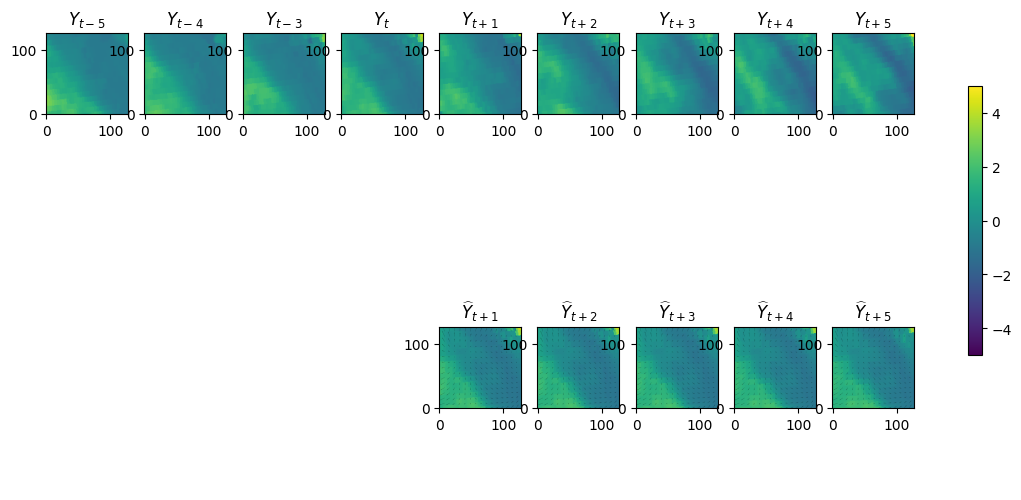

Sample 1:
t+1 MSE loss: 0.0981	t+2 MSE loss: 0.1089	t+3 MSE loss: 0.2516	t+4 MSE loss: 0.4920	t+5 MSE loss: 0.5664	

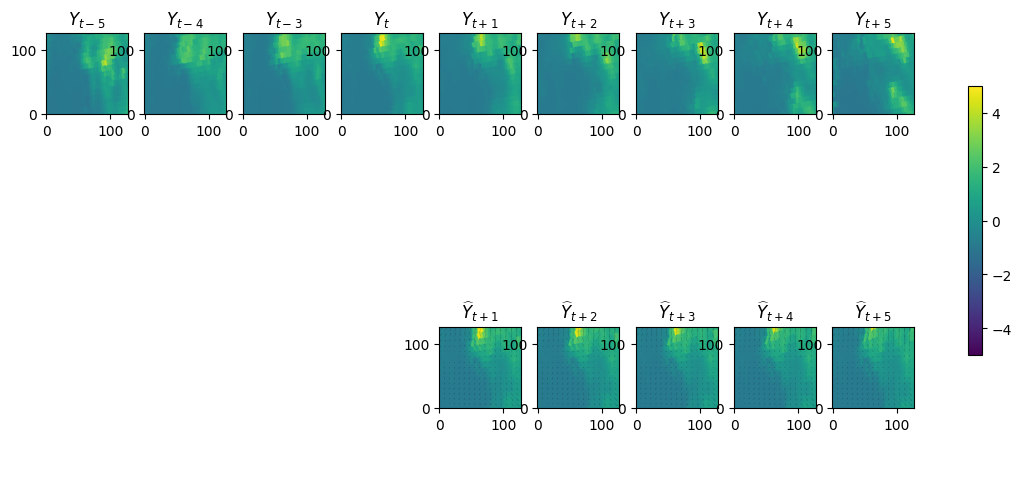

Sample 2:
t+1 MSE loss: 0.2243	t+2 MSE loss: 0.2435	t+3 MSE loss: 0.6332	t+4 MSE loss: 1.0484	t+5 MSE loss: 1.4245	

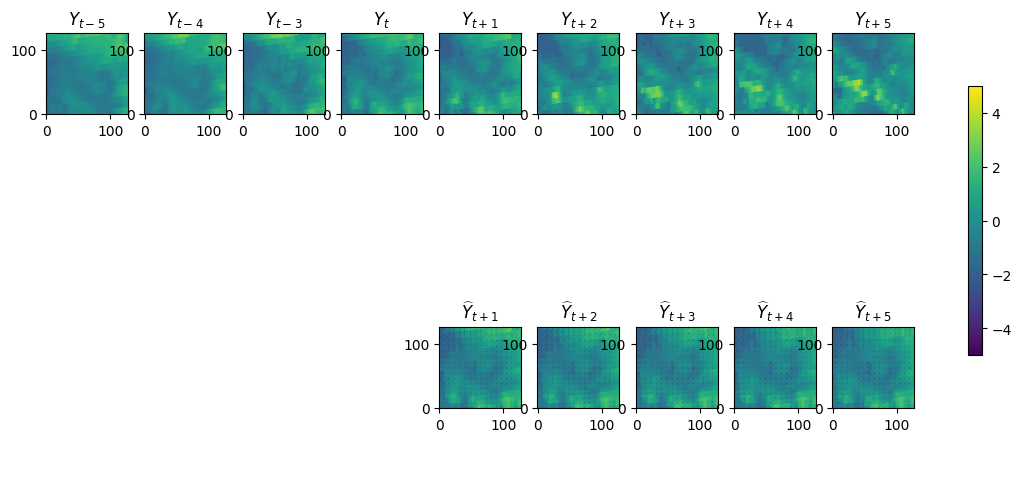

Sample 3:
t+1 MSE loss: 0.2778	t+2 MSE loss: 0.2880	t+3 MSE loss: 0.5616	t+4 MSE loss: 0.8250	t+5 MSE loss: 0.8837	

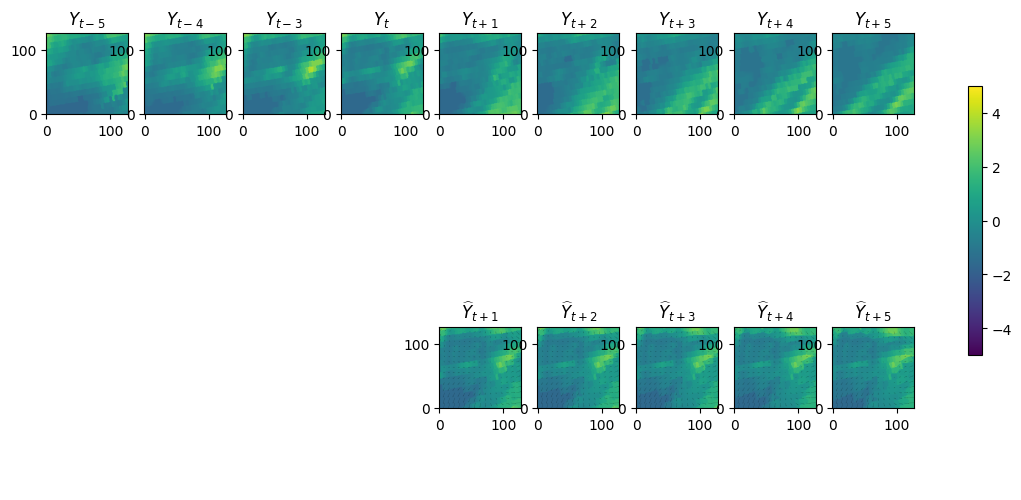

Sample 4:
t+1 MSE loss: 0.2083	t+2 MSE loss: 0.2144	t+3 MSE loss: 0.3429	t+4 MSE loss: 0.4105	t+5 MSE loss: 0.4512	

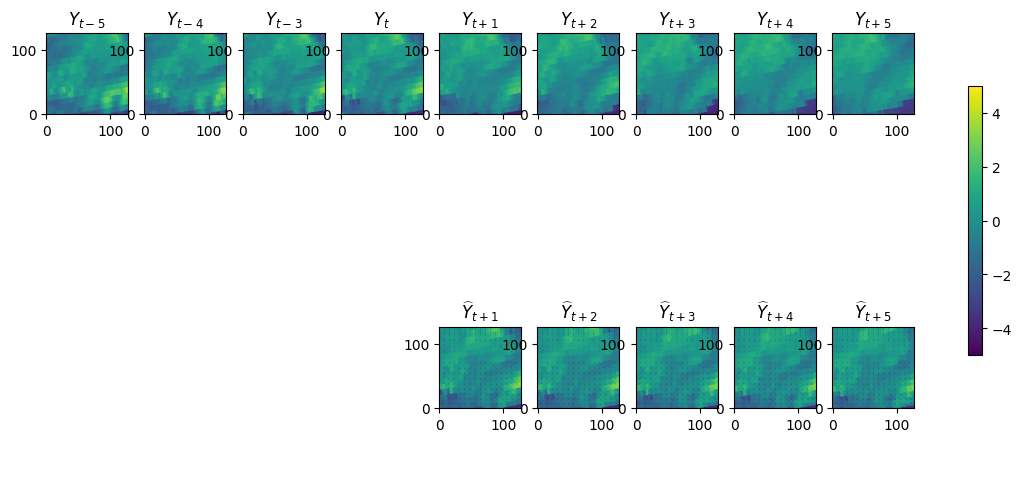

Sample 5:
t+1 MSE loss: 0.1568	t+2 MSE loss: 0.1748	t+3 MSE loss: 0.3441	t+4 MSE loss: 0.6483	t+5 MSE loss: 0.8333	

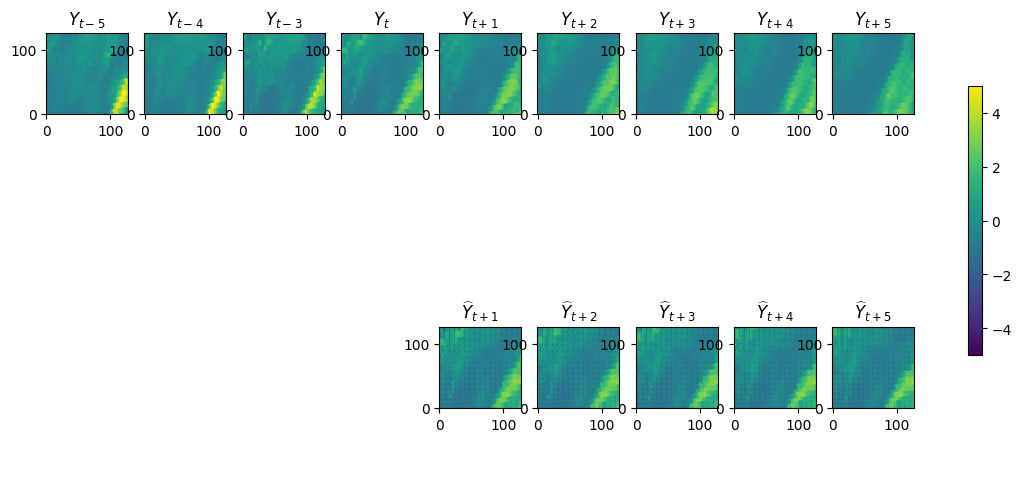

Sample 6:
t+1 MSE loss: 0.0745	t+2 MSE loss: 0.0750	t+3 MSE loss: 0.1311	t+4 MSE loss: 0.1486	t+5 MSE loss: 0.1547	

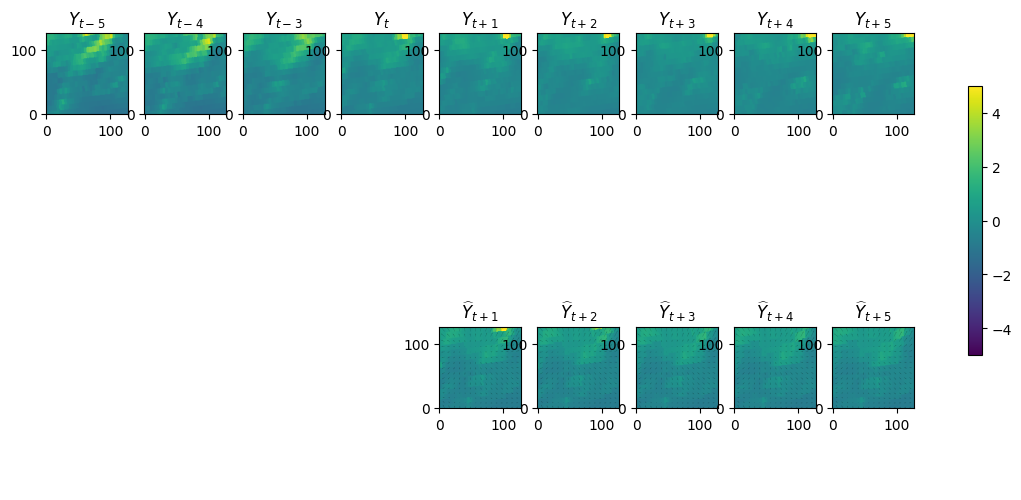

Sample 7:
t+1 MSE loss: 0.5522	t+2 MSE loss: 0.5251	t+3 MSE loss: 0.9128	t+4 MSE loss: 1.0853	t+5 MSE loss: 1.0389	

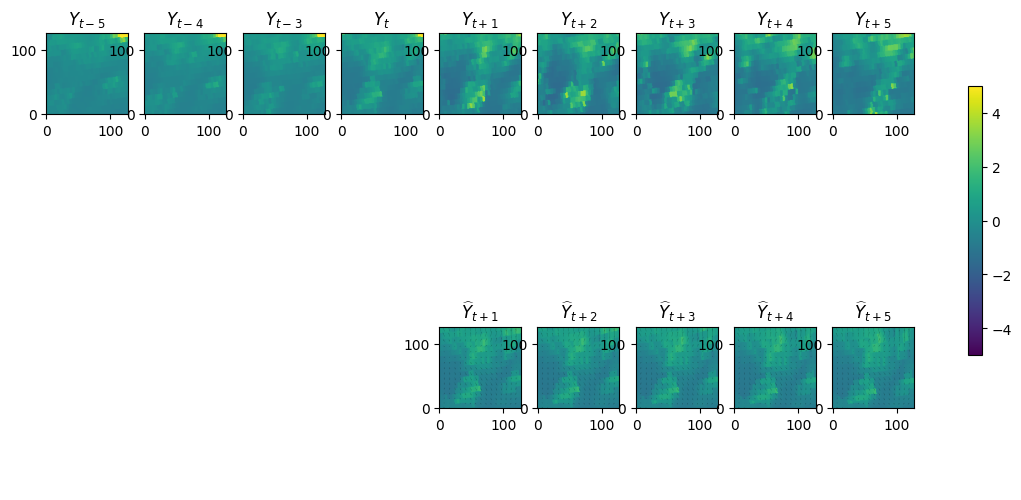

Sample 8:
t+1 MSE loss: 0.1035	t+2 MSE loss: 0.1060	t+3 MSE loss: 0.2563	t+4 MSE loss: 0.3227	t+5 MSE loss: 0.3180	

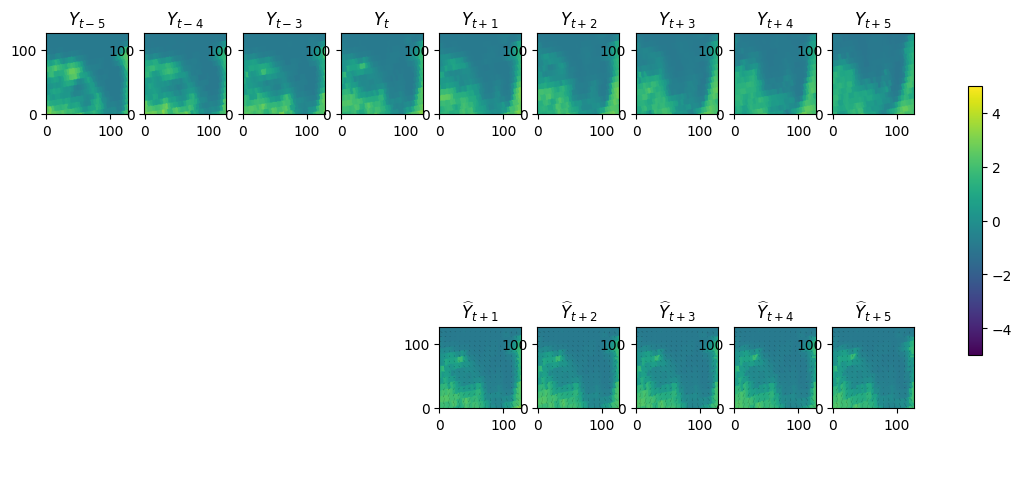

Sample 9:
t+1 MSE loss: 0.3736	t+2 MSE loss: 0.3998	t+3 MSE loss: 0.7012	t+4 MSE loss: 0.7811	t+5 MSE loss: 0.7938	

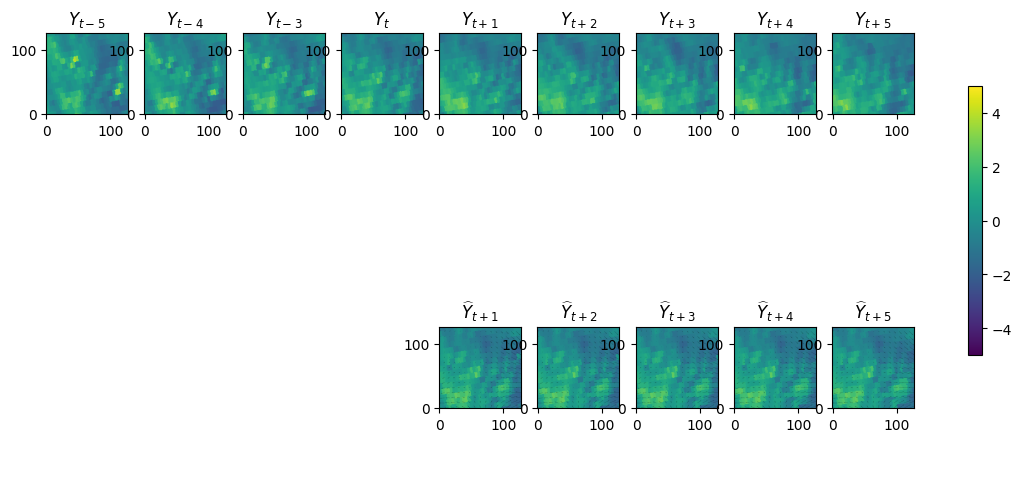

Sample 10:
t+1 MSE loss: 0.1456	t+2 MSE loss: 0.1614	t+3 MSE loss: 0.3839	t+4 MSE loss: 0.5426	t+5 MSE loss: 0.6874	

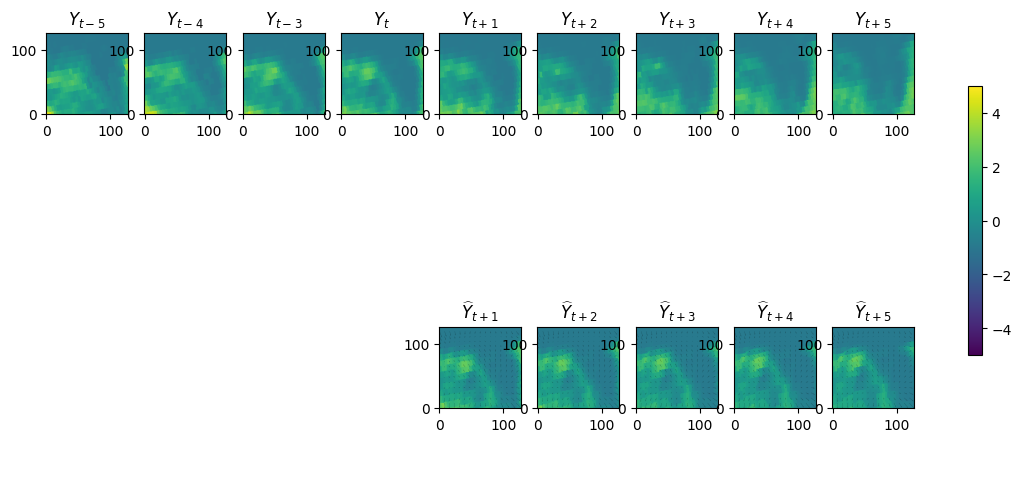

Sample 11:
t+1 MSE loss: 0.0375	t+2 MSE loss: 0.0489	t+3 MSE loss: 0.0873	t+4 MSE loss: 0.1762	t+5 MSE loss: 0.2256	

KeyboardInterrupt: 

In [10]:
for sample_i, sample in enumerate(datamodule.test_dataloader()):
    print("Sample {}:".format(sample_i))
    output, flow = model.predict_step(sample[:,0:lags],0)
    print("t+1 MSE loss: {:0.4f}".format(F.mse_loss(mask(output[:,-1], masking), mask(sample[:,lags], masking)).item()), end="\t")
    predictions = output[:,-1]
    vectors = flow
    for i in range(sample.shape[1]-lags-1):
        #output, flow = model.predict_step(output, 0)
        output = warp(predictions[-1].unsqueeze(0), flow, "nearest")
        y_hat = output[:,-1]
        y = sample[:,i+lags]
        loss = F.mse_loss(mask(y_hat, masking), mask(y, masking)).item()
        print("t+{} MSE loss: {:0.4f}".format(i+2, loss), end="\t")
        predictions = torch.cat([predictions, y_hat], dim=0)
        vectors = torch.cat([vectors, flow], dim=0)
    f = plot_time_steps(sample.squeeze(), predictions, vectors)
    plt.show()
        
create_animation(torch.cat((sample.squeeze()[0:lags]/0.0, predictions)).cpu().detach().numpy(), 64*torch.cat([torch.zeros(lags, 2, hparams["img_size"], hparams["img_size"]), vectors]).cpu().detach().numpy(), None, data2=sample.squeeze().cpu().detach().numpy())

In [20]:
gaus.shape

(15, 64, 64)

In [24]:
gaus[3:11].shape

(8, 64, 64)

In [51]:
_[:,1] = torch.zeros_like(_[:,1])

In [52]:
_

tensor([[[ 0.1229, -0.0006,  0.0526, -0.0664, -0.0951,  0.0127],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<CopySlices>)

In [63]:
_

tensor([[[ 0.1229, -0.0006,  0.0526, -0.0664, -0.0951,  0.0127],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<CopySlices>)

In [100]:
filt = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, padding="same", bias=False)

In [101]:
filt(_[:,0])

tensor([[ 0.0693,  0.0358,  0.0002, -0.0411, -0.0401,  0.0306]],
       grad_fn=<SqueezeBackward1>)

In [102]:
from scipy import signal
g = signal.gaussian(6, 1)

In [83]:
filt.weight.data.copy_(torch.tensor(g).float())

tensor([[[3.7267e-06, 2.4935e-01, 2.4935e-01, 3.7267e-06]]])

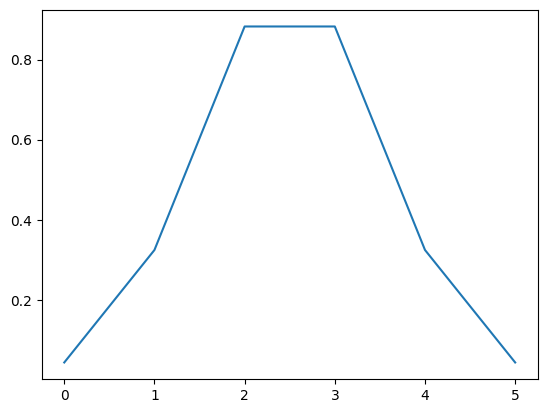

In [103]:
plt.plot(g)

In [112]:
torch.randn(32,6) + torch.mean(torch.randn(32,6), dim=1).unsqueeze(1)

tensor([[ 0.7317,  0.8416, -0.4318, -0.7211, -0.0872, -0.7935],
        [-1.0206, -0.8268,  0.1304,  3.3216,  0.3631,  2.1036],
        [-0.1689, -0.7998, -1.6528,  1.1254, -1.3096, -2.2870],
        [ 1.9245,  1.3899,  1.3813, -0.1079, -1.5830,  0.1463],
        [-1.2240,  0.3026, -0.5064, -1.5096,  1.0763,  1.2645],
        [-0.9426, -0.2372,  1.5491, -0.7404, -1.3646,  1.3697],
        [-1.1536, -0.8442,  0.0446,  1.2756,  0.1552,  0.1565],
        [ 1.1613, -1.0180,  0.1566, -0.4532, -2.2139, -1.3025],
        [ 0.4379,  1.1222,  1.3694,  0.5429,  0.5403,  1.3416],
        [ 0.0782, -0.0735,  0.7998,  1.1026,  0.0084, -1.5126],
        [-0.9888, -0.9940,  0.6841, -0.0776, -1.0687, -1.4614],
        [ 0.6266, -1.3108, -1.6790, -0.2993, -0.1697,  1.2558],
        [ 1.7815, -1.1011, -0.7937,  0.7402,  0.5021, -1.0971],
        [ 0.2920, -0.7654, -0.4168, -0.4688, -1.4219, -0.3434],
        [ 0.7371,  0.4658, -0.6268, -1.2326,  0.9684, -0.9949],
        [ 1.4249,  1.5570, -0.0864, -0.5

In [104]:
_.shape

torch.Size([1, 2, 6])

In [108]:
torch.mean(_, dim=2)

tensor([[0.0043, 0.0000]], grad_fn=<MeanBackward1>)

In [40]:
F.upsample(_, size=(6), mode="linear")

tensor([[[ 0.1229, -0.0006,  0.0526, -0.0664, -0.0951,  0.0127],
         [ 0.0169, -0.0015, -0.0696, -0.0443,  0.0275, -0.0809]]],
       grad_fn=<UpsampleLinear1DBackward0>)

In [21]:
checkpoint['state_dict']['enc_i.attention.weight']

tensor([[[[ 0.0918]],

         [[-0.0041]],

         [[-0.0492]]]], device='cuda:0')

In [36]:
1e-02

0.01

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


t+1 MSE loss: 0.0583	t+2 MSE loss: 0.0540	t+3 MSE loss: 0.0440	t+4 MSE loss: 0.0346	t+5 MSE loss: 0.0316	

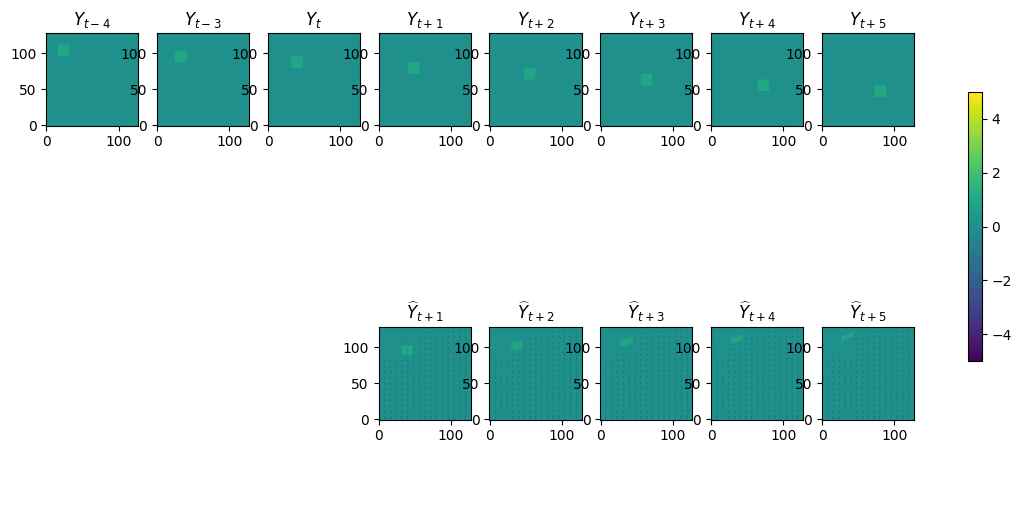

In [34]:
gaus = np.load('square.npy')
gaus = np.flip(gaus, 1)
sample = torch.tensor(gaus[3:11].copy(), device='cuda').float()
#sample = F.pad(sample, [32]*4).unsqueeze(0)*4
sample = F.upsample(sample.unsqueeze(0), size=(256,256), mode="nearest")*1
sample = sample[...,64:192,64:192]
output, flow, _ = model.predict_step(sample[:,0:lags],0)
print("t+1 MSE loss: {:0.4f}".format(F.mse_loss(mask(output[:,-1], masking), mask(sample[:,lags], masking)).item()), end="\t")
predictions = output[:,-1]
#flow =( flow * (flow.shape[2] - 1)) / 2
vectors = flow
for i in range(sample.shape[1]-lags-1):
    #output, flow = model.predict_step(output, 0)
    output = warp(predictions[-1].unsqueeze(0), flow, "nearest")
    y_hat = output[:,-1]
    y = sample[:,i+lags]
    loss = F.mse_loss(mask(y_hat, masking), mask(y, masking)).item()
    print("t+{} MSE loss: {:0.4f}".format(i+2, loss), end="\t")
    predictions = torch.cat([predictions, y_hat], dim=0)
    vectors = torch.cat([vectors, flow], dim=0)
f = plot_time_steps(sample.squeeze(), predictions, vectors)
plt.show()
create_animation(predictions.cpu().detach().numpy(), vectors.cpu().detach().numpy(), None, data2=sample[0][-predictions.shape[0]:].cpu().detach().numpy(), vlim=[0,1])

In [94]:
model.to("cuda:0")

BasisFunctionModel(
  (enc_i): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (group1): GroupOfBlocks(
      (group): Sequential(
        (0): Block(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU()
        )
        (1): Block(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (batchnorm1): Batc

In [18]:
from dlm import dlmsmo_dr, dlmsmo
from dlm.modelutils import matern32L, paddata, unpaddata
from dlm.basis import makeproj
#from dlm import datautils
from dlm import modelutils
from scipy.sparse.linalg import aslinearoperator

In [77]:
x_test0 = sample[0,0:lags,:,:].cpu().detach().numpy()
x_test = sample[0,:,:,:].reshape(sample.shape[1],128**2).cpu().detach().numpy()

In [78]:
fitdata = np.ones((sample.shape[1]-lags, nx*ny*lags), dtype=np.float32)
for i in range(sample.shape[1]-lags):
    fitdata[i] = x_test[0+i:lags+i].flatten()

In [98]:
def Mfun(x):
    x = torch.tensor(x, dtype=torch.float32)
    x = x.reshape(lags,128,128).unsqueeze(0).to("cuda:0")
    #print(x.shape)
    output, flow = model.predict_step(x,0)
    y_hat = output[0,-1]
    #print(y_hat.device)
    return y_hat.cpu().detach().numpy()

In [103]:
for i in range(lags*n):
    M(x0)
    print(i, end="\r")

KeyboardInterrupt: 

In [104]:
n = 128*128
nx = 128
ny = 128
dx = 1
dy = 1

obsError = 0.01  # relative error when using logs
modelError = 0.10
corrLength = 2000 # relative to h, now in meters
alpha = 0.97
alpha = 1
# Observation operator is identity
H = sp.eye(n, dtype=np.float32).tocsr()
R = obsError
# AR(1) diagonal model
# M = sp.eye(n).tocsr() * alpha
M = LinearOperator(matvec=Mfun,shape=(nx**2,lags*ny**2), dtype=np.float32)
# Model error covariance as sparse precision matrix
C0 = np.eye(lags*n, dtype=np.float32) * 0.25
Qi = matern32L(nx, ny, h=dx, l=corrLength, sig=modelError).astype(np.float32).tocsr()
Qi = Qi.dot(Qi.T)
if alpha < 1:
    Qi = Qi / (1.0 - alpha**2)


In [105]:
x0 = x_test0.flatten()
fitdata = fitdata
xs, xstd = dlmsmo(fitdata, H, R, x0, M, Qi, C0, smooth=False)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (16384,16384)  and requested shape (49152,49152)

In [ ]:
for sample_i, sample in enumerate(datamodule.test_dataloader()):
    print("Sample {}:".format(sample_i))
    output, flow = model.predict_step(sample[:,0:lags],0)
    print("t+1 MSE loss: {:0.4f}".format(F.mse_loss(mask(output[:,-1], masking), mask(sample[:,lags], masking)).item()), end="\t")
    predictions = output[:,-1]
    vectors = flow
    for i in range(sample.shape[1]-lags-1):
        #output, flow = model.predict_step(output, 0)
        output = warp(predictions[-1].unsqueeze(0), flow, "nearest")
        y_hat = output[:,-1]
        y = sample[:,i+lags]
        loss = F.mse_loss(mask(y_hat, masking), mask(y, masking)).item()
        print("t+{} MSE loss: {:0.4f}".format(i+2, loss), end="\t")
        predictions = torch.cat([predictions, y_hat], dim=0)
        vectors = torch.cat([vectors, flow], dim=0)
    f = plot_time_steps(sample.squeeze(), predictions, vectors)
    plt.show()
    if sample_i == 0:
        break
        
create_animation(torch.cat((sample.squeeze()[0:lags]/0.0, predictions)).cpu().detach().numpy(), 64*torch.cat([torch.zeros(lags, 2, hparams["img_size"], hparams["img_size"]), vectors]).cpu().detach().numpy(), None, data2=sample.squeeze().cpu().detach().numpy())


In [107]:
from pysteps import nowcasts, motion
I = sample[0].cpu().detach().numpy()
I.shape
s = 3 # start
n_steps = 3 #number of images used to estimate the motion field
imgs = np.log(I[0:s]+1) #log transform leads to better results
dense_lucaskanade = motion.get_method("LK")
u2,v2 = dense_lucaskanade(imgs,fd_method="shitomasi",
                             dense=True,
                             size_opening=2, decl_scale=10,
                             fd_kwargs={'max_corners':100,'buffer_mask':10},
                             lk_kwargs={'winsize':(10,10), 'nr_levels':3},
                             k_outlier=None,
                             nr_std_outlier=2,
                             verbose=True)

w = np.stack((u2,v2))

extrapolate = nowcasts.get_method("extrapolation")
n_leadtimes = 4
extrapolation_solution = extrapolate(I[s-1],w,4)
create_animation(extrapolation_solution, np.array([w]*4), None, data2=I[-4:], out_name="lk.gif")

Computing the motion field with the Lucas-Kanade method.
--- 7 outliers detected ---
--- LK found 66 sparse vectors ---
--- 58 samples left after declustering ---


MovieWriter ffmpeg unavailable; using Pillow instead.


--- total time: 1.33 seconds ---
